In [11]:
colors = {
    "p53": "#008DD5",
    "nutlin": "#DB5461",
    "nfkb": "#C33149",
    "tnf": "#107E7D",
    "gray": "#DAE0DC"
}

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from tqdm import tqdm
import pickle
import gzip
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})

In [13]:
# defining parameters from Krishna/Jensen

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1.0 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M


# Mean value for TNF oscillations
k = 0.5

In [14]:
# This is fetched from "nfkappab.ipynb" where we calculated it with constant TNF = 0.5
x0 = [0.038121575605998374, 0.4043266277640023, 4.065919561814218, 0.1799999999999994, 1.5500000000000014]
T_int = 108.47222222222223
A_int = 0.12940028915485896

In [15]:
# defining equations from Krishna/Jensen
def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dN_ndt = k_Nin * (N_tot - N_n) * K_I / (K_I + I) - k_lin * I * (N_n / (K_N + N_n))
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dI_mdt = k_t * (N_n**2) - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIdt = k_tl * I_m - alpha * IKK_a * (N_tot - N_n) * I / (K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt

def system_nfkb(t, y, A_ext, T_ext):
    # Extract current state variables, assume TNF is not part of y here
    N_n, I_m, I, IKK_a, IKK_i = y

    # Dynamically compute TNF based on current time t (this means it will be a constant passed to the next equations for this dt)
    TNF = k + A_ext * np.sin(2 * np.pi * (1 / T_ext) * t)

    return [N_n_change(t, *y, TNF), 
            I_m_change(t, *y, TNF), 
            I_change(t, *y, TNF), 
            IKK_a_change(t, *y, TNF), 
            IKK_i_change(t, *y, TNF)]

In [16]:
def TNF_sin_osc(oscillations, T_internal, A_ext, OOmega = None, T_external = None):
    if (not T_external and OOmega):
        T_external = OOmega * T_internal
    if (not OOmega and T_external):
        OOmega = T_external / T_internal

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}
    
    for i in tqdm(range(oscillations)):
        if i == 0:
            state = x0
        else:
            state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1]

        sys = solve_ivp(system_nfkb, (0, T_external), state, args=(A_ext, T_external,), method='LSODA', max_step=0.1, dense_output=True)
        
        N_n, I_m, I, IKK_a, IKK_i = sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]

        new_t = np.array(sys["t"]) + (history["t"][-1] if history["t"] else 0)
        history["t"].extend(new_t)
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(k + A_ext * np.sin(2*np.pi * (1 / T_external) * new_t))

    return history, T_external, OOmega

In [98]:
no_osc = 400

# defining omega amplitude, TNF_0 and start parameters as the last values of the first simulation
current_omega = 1
coupling_strength = 2.9

TNF_amp = A_int * coupling_strength

TNF_period = current_omega * T_int

In [99]:
# simulating system with sinus oscillations
simulation, T_TNF, OOmega = TNF_sin_osc(oscillations = no_osc, T_internal = T_int, A_ext = TNF_amp, OOmega = None, T_external=TNF_period)

100%|██████████| 400/400 [00:39<00:00, 10.23it/s]


In [100]:
# unpacking
t_sim, N_n_sim, I_m_sim, I_sim, IKK_a_sim, IKK_i_sim, TNF_sim = np.array(simulation["t"]), np.array(simulation["N_n"]), np.array(simulation["I_m"]), np.array(simulation["I"]), np.array(simulation["IKK_a"]), np.array(simulation["IKK_i"]), np.array(simulation["TNF"])

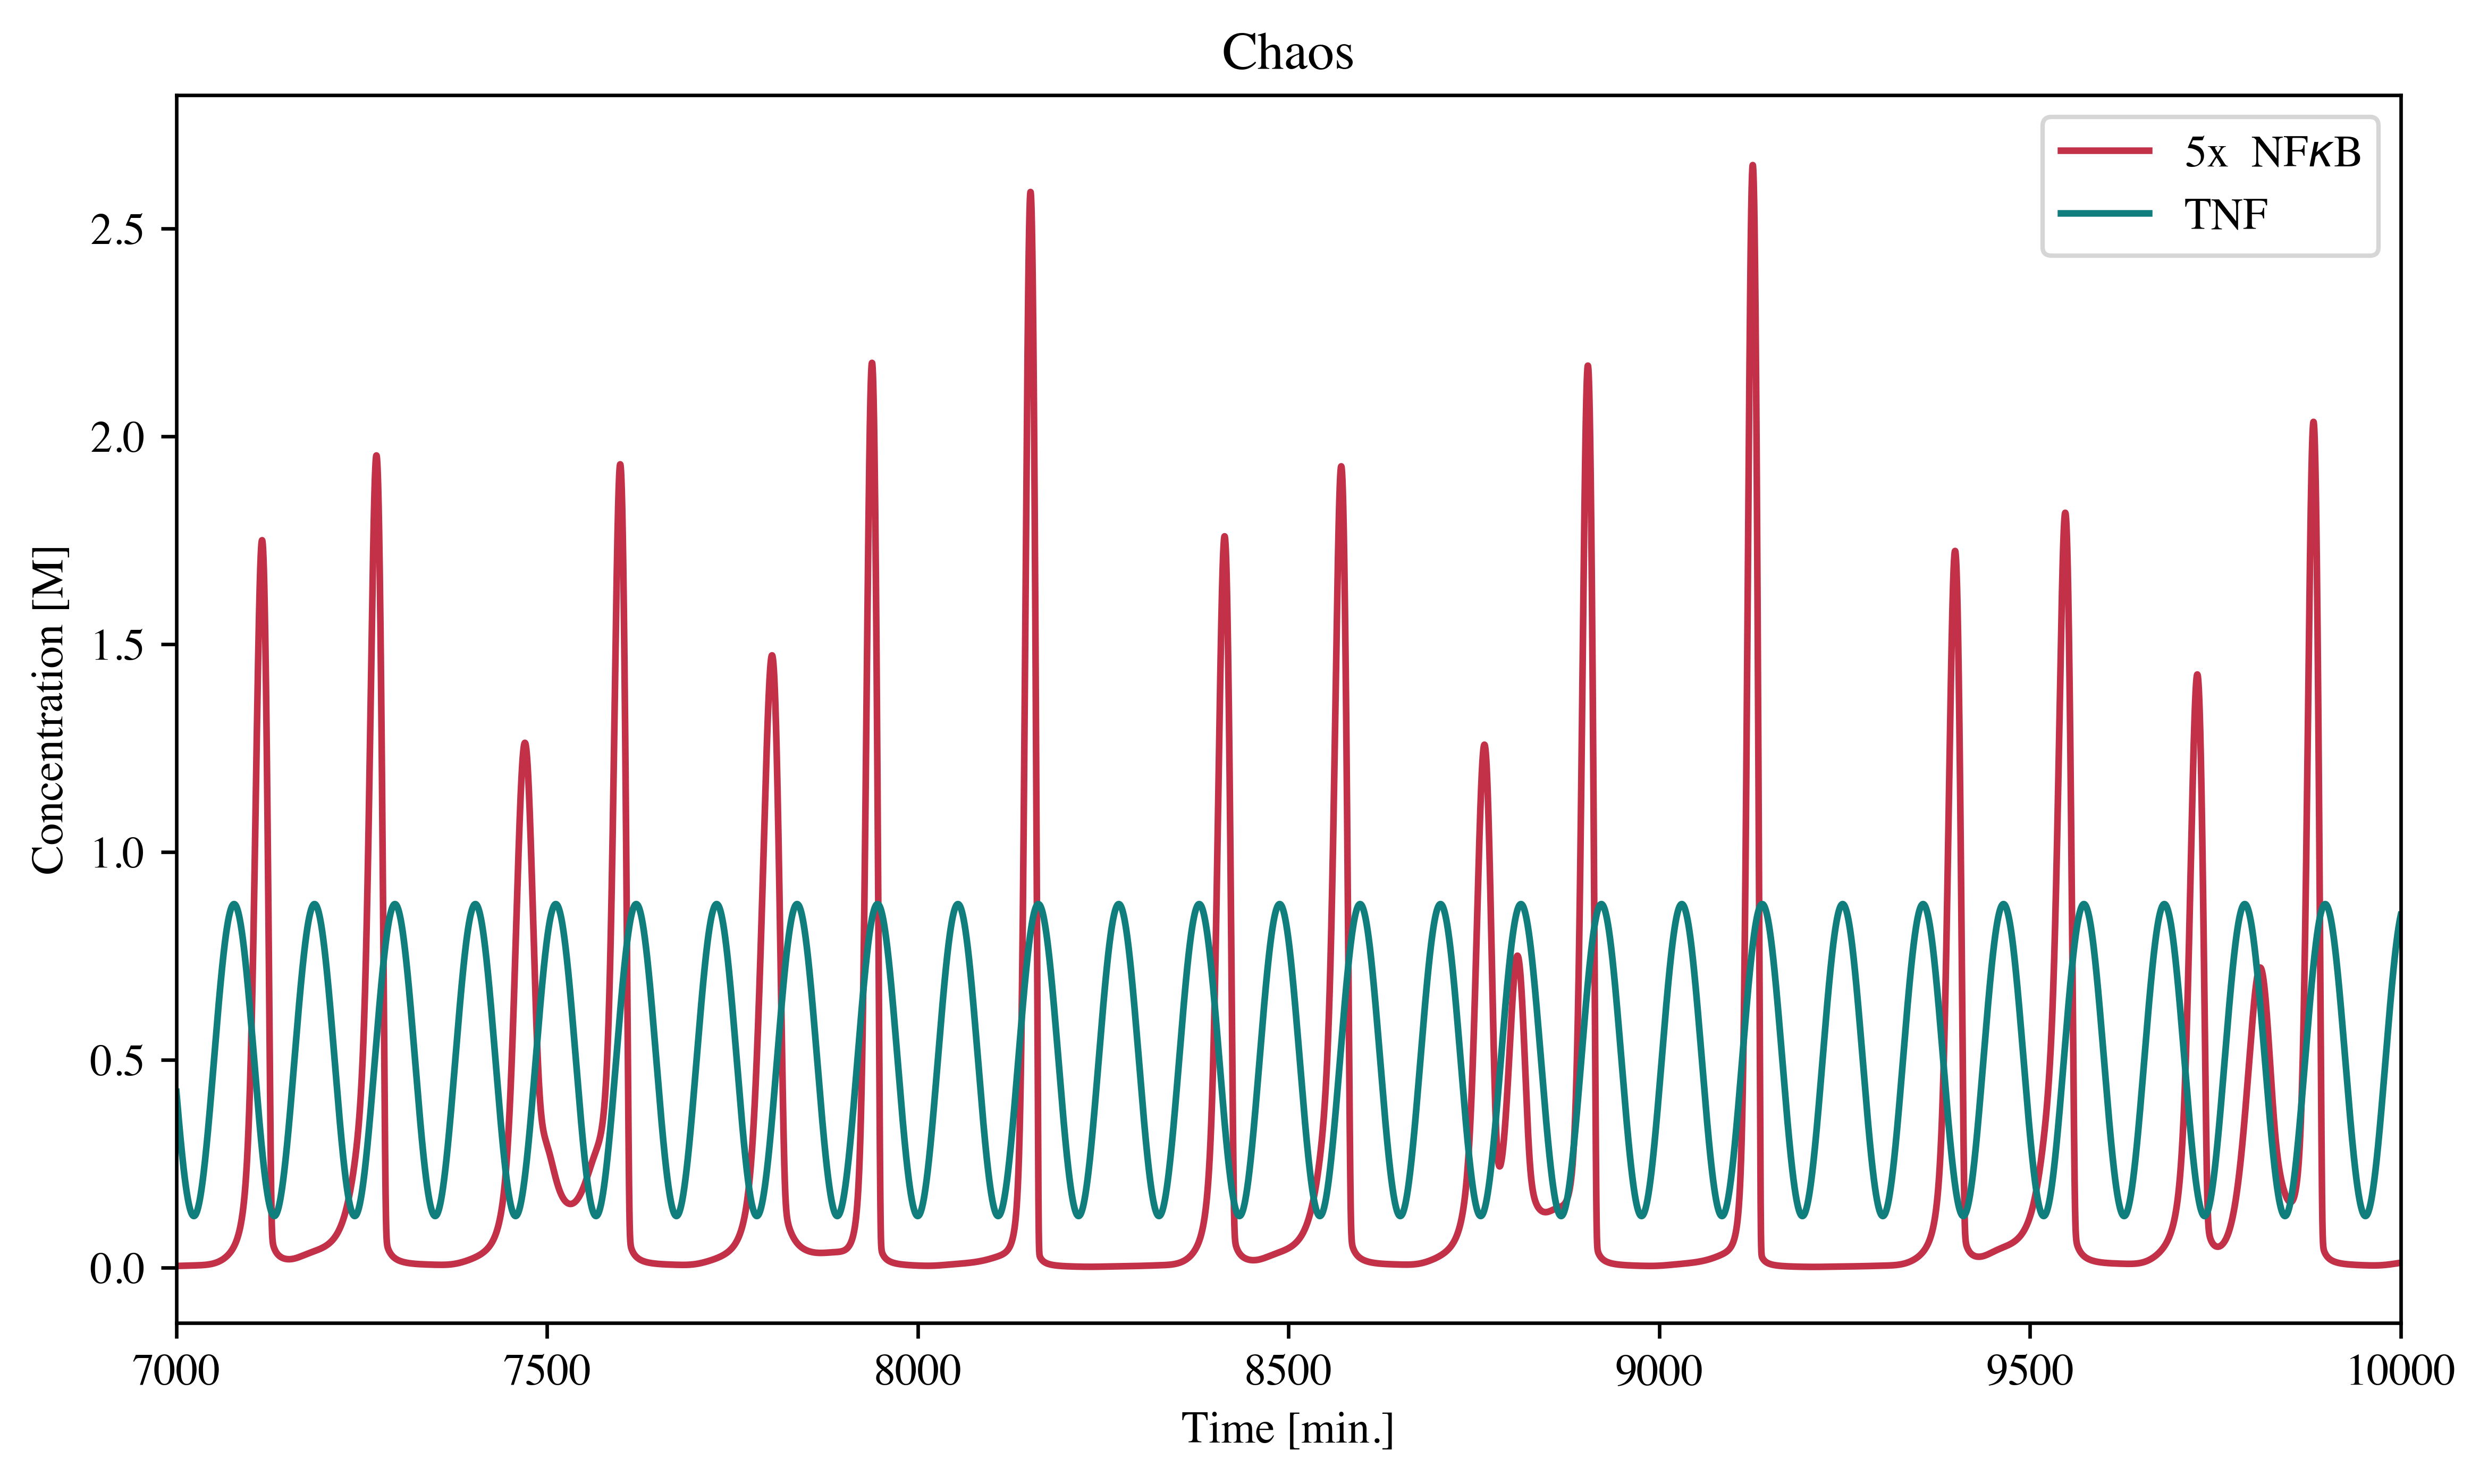

In [105]:
plt.figure(dpi=600, figsize=(9,5))
x = 5
plt.plot(t_sim, x*N_n_sim, color=colors["nfkb"], alpha=1, label = f'{x}x  NF$\kappa$B')
plt.plot(t_sim, TNF_sim, alpha=1, color=colors["tnf"], label = f'TNF')
plt.title(rf'Chaos')
plt.xlim(7000, 10000)
plt.xlabel('Time [min.]')
plt.ylabel('Concentration [M]')
plt.legend()